## Bearing Failure Anomaly Detection
In this workbook, we use an autoencoder neural network to identify vibrational anomalies from sensor readings in a set of bearings. The goal is to be able to predict future bearing failures before they happen. The vibrational sensor readings are from the NASA Acoustics and Vibration Database. Each data set consists of individual files that are 1-second vibration signal snapshots recorded at 10 minute intervals. Each file contains 20,480 sensor data points that were obtained by reading the bearing sensors at a sampling rate of 20 kHz.

The autoencoder neural network model is created using dense hidden unit cells within the Keras / TensorFlow framework.

In [1]:
# import libraries
import os
import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
sns.set(color_codes=True)
import matplotlib.pyplot as plt
%matplotlib inline

from numpy.random import seed
from tensorflow import set_random_seed

from keras.layers import Input, Dropout, Dense
from keras.models import Model, Sequential, load_model
from keras import regularizers
from keras.models import model_from_json

Using TensorFlow backend.


# Data loading and pre-processing
An assumption is that mechanical degradation in the bearings occurs gradually over time; therefore, we use one datapoint every 10 minutes in the analysis. Each 10 minute datapoint is aggregated by using the mean absolute value of the vibration recordings over the 20,480 datapoints in each file. We then merge together everything in a single dataframe.

In [2]:
# load, average and merge sensor samples
data_dir = 'data/bearing_vibe'
merged_data = pd.DataFrame()

for filename in os.listdir(data_dir):
    dataset = pd.read_csv(os.path.join(data_dir, filename), sep='\t')
    dataset_mean_abs = np.array(dataset.abs().mean())
    dataset_mean_abs = pd.DataFrame(dataset_mean_abs.reshape(1,4))
    dataset_mean_abs.index = [filename]
    merged_data = merged_data.append(dataset_mean_abs)
    
merged_data.columns = ['Bearing 1', 'Bearing 2', 'Bearing 3', 'Bearing 4']

In [3]:
# transform data file index to datatime and sort in chronological order
merged_data.index = pd.to_datetime(merged_data.index, format='%Y.%m.%d.%H.%M.%S')
merged_data = merged_data.sort_index()
merged_data.to_csv('Averaged_BearingTest_Dataset.csv')
print("Dataset shape:", merged_data.shape)
merged_data.head()

Dataset shape: (984, 4)


,Bearing 1,Bearing 2,Bearing 3,Bearing 4
2004-02-12 10:32:39,0.058333,0.071832,0.083242,0.043067
2004-02-12 10:42:39,0.058995,0.074006,0.084435,0.044541
2004-02-12 10:52:39,0.060236,0.074227,0.083926,0.044443
2004-02-12 11:02:39,0.061455,0.073844,0.084457,0.045081
2004-02-12 11:12:39,0.061361,0.075609,0.082837,0.045118


# Define train/test data
Before setting up the models, we need to define train/test data. To do this, we perform a simple split where we train on the first part of the dataset (which should represent normal operating conditions) and test on the remaining parts of the dataset leading up to the bearing failure.

In [4]:
train = merged_data['2004-02-12 10:32:39': '2004-02-15 12:52:39']
test = merged_data['2004-02-15 12:52:39':]
print("Training dataset shape:", train.shape)
print("Test dataset shape:", test.shape)

Training dataset shape: (447, 4)
Test dataset shape: (538, 4)


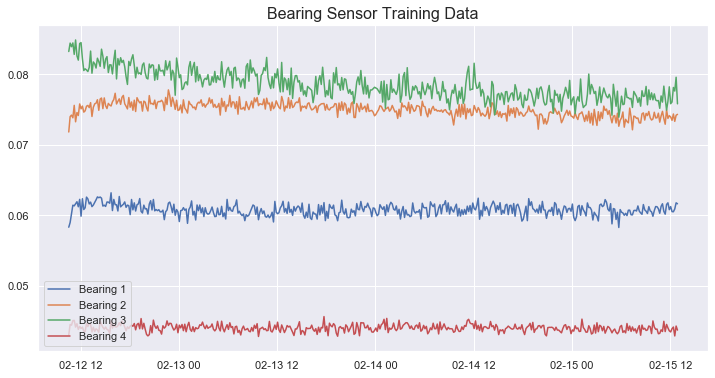

In [6]:
# plot training data
fig, ax = plt.subplots(figsize=(12,6))
ax.plot(train['Bearing 1'], label='Bearing 1')
ax.plot(train['Bearing 2'], label='Bearing 2')
ax.plot(train['Bearing 3'], label='Bearing 3')
ax.plot(train['Bearing 4'], label='Bearing 4')
plt.legend(loc='lower left')
ax.set_title('Bearing Sensor Training Data', fontsize=16)
plt.show()

In [7]:
# normalize the data
scaler = MinMaxScaler()
X_train = scaler.fit_transform(train)
X_test = scaler.transform(test)

In [8]:
# set random seed
seed(10)
set_random_seed(10)

In [9]:
# define the autoencoder network model
def autoencoder_model(X):
    initializer = 'glorot_uniform'
    inputs = Input(shape=(X.shape[1],))
    L1 = Dense(12, activation='relu', kernel_initializer=initializer, 
               kernel_regularizer=regularizers.l2(0.00))(inputs)
    L2 = Dense(3, activation='relu', kernel_initializer=initializer)(L1)
    L3 = Dense(12, activation='relu', kernel_initializer=initializer)(L2)
    output = Dense(X.shape[1], activation='relu', kernel_initializer=initializer)(L3)
    model = Model(inputs=inputs, outputs=output)
    return model

In [10]:
# create the autoencoder model
model = autoencoder_model(X_train)
model.compile(optimizer='adam', loss='mse')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 4)                 0         
_________________________________________________________________
dense_1 (Dense)              (None, 12)                60        
_________________________________________________________________
dense_2 (Dense)              (None, 3)                 39        
_________________________________________________________________
dense_3 (Dense)              (None, 12)                48        
_________________________________________________________________
dense_4 (Dense)              (None, 4)                 52        
Total params: 199
Trainable params: 199
Non-trainable params: 0
_________________________________________________________________


In [11]:
# fit the model
nb_epochs = 100
batch_size = 10
history = model.fit(X_train, X_train, epochs=nb_epochs, batch_size=batch_size, validation_split=0.05).history

Train on 424 samples, validate on 23 samples
Epoch 1/100
424/424 [==============================] - 0s 825us/step - loss: 0.1870 - val_loss: 0.0710
Epoch 2/100
424/424 [==============================] - 0s 232us/step - loss: 0.0497 - val_loss: 0.0302
Epoch 3/100
424/424 [==============================] - 0s 227us/step - loss: 0.0204 - val_loss: 0.0254
Epoch 4/100
424/424 [==============================] - 0s 238us/step - loss: 0.0191 - val_loss: 0.0243
Epoch 5/100
424/424 [==============================] - 0s 228us/step - loss: 0.0187 - val_loss: 0.0233
Epoch 6/100
424/424 [==============================] - 0s 284us/step - loss: 0.0182 - val_loss: 0.0223
Epoch 7/100
424/424 [==============================] - 0s 188us/step - loss: 0.0177 - val_loss: 0.0222
Epoch 8/100
424/424 [==============================] - 0s 250us/step - loss: 0.0172 - val_loss: 0.0208
Epoch 9/100
424/424 [==============================] - 0s 209us/step - loss: 0.0167 - val_loss: 0.0210
Epoch 10/100
424/424 [======

424/424 [==============================] - 0s 161us/step - loss: 0.0050 - val_loss: 0.0063
Epoch 80/100
424/424 [==============================] - 0s 192us/step - loss: 0.0049 - val_loss: 0.0063
Epoch 81/100
424/424 [==============================] - 0s 197us/step - loss: 0.0048 - val_loss: 0.0070
Epoch 82/100
424/424 [==============================] - 0s 150us/step - loss: 0.0049 - val_loss: 0.0061
Epoch 83/100
424/424 [==============================] - 0s 225us/step - loss: 0.0048 - val_loss: 0.0060
Epoch 84/100
424/424 [==============================] - 0s 229us/step - loss: 0.0047 - val_loss: 0.0059
Epoch 85/100
424/424 [==============================] - 0s 194us/step - loss: 0.0047 - val_loss: 0.0058
Epoch 86/100
424/424 [==============================] - 0s 193us/step - loss: 0.0046 - val_loss: 0.0059
Epoch 87/100
424/424 [==============================] - 0s 167us/step - loss: 0.0046 - val_loss: 0.0058
Epoch 88/100
424/424 [==============================] - 0s 135us/step - loss:

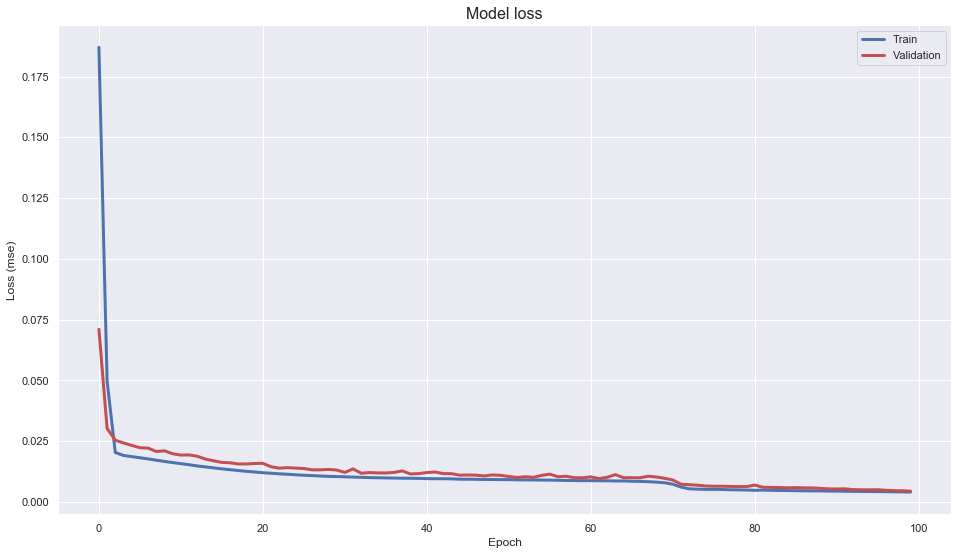

In [12]:
# plot training losses
fig, ax = plt.subplots(figsize=(16,9))
ax.plot(history['loss'], 'b', label='Train', linewidth=3)
ax.plot(history['val_loss'], 'r', label='Validation', linewidth=3)
ax.set_title('Model loss', fontsize=16)
ax.set_ylabel('Loss (mse)')
ax.set_xlabel('Epoch')
ax.legend(loc='upper right')
plt.show()

# Distribution of Loss Function
By plotting the distribution of the calculated loss in the training set, one can use this to identify a suitable threshold value for identifying an anomaly. In doing this, one can make sure that this threshold is set above the “noise level”, and that any flagged anomalies should be statistically significant above the noise background.

(0.0, 0.5)

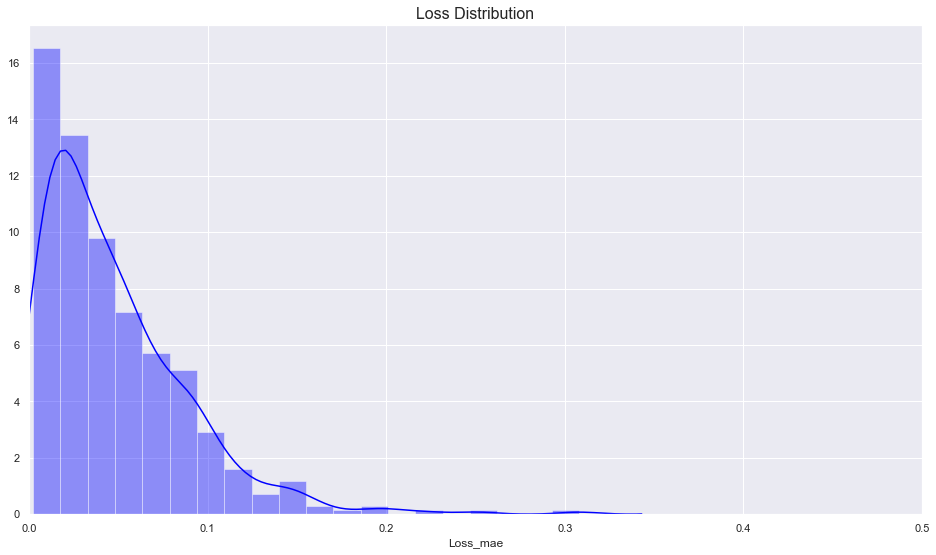

In [13]:
# plot the loss distribution on the training set
X_pred = model.predict(X_train)
X_pred = pd.DataFrame(X_pred, columns=train.columns)
X_pred.index = train.index

scored = pd.DataFrame(index=train.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_train), axis = 1)
plt.figure(figsize=(16,9))
plt.title('Loss Distribution', fontsize=16)
sns.distplot(scored['Loss_mae'],
             bins = 20, 
             kde= True,
            color = 'blue');
plt.xlim([0.0,.5])

From the above loss distribution, let us try a threshold of 0.25 for flagging an anomaly. We can then calculate the loss in the test set to check when the output crosses the anomaly threshold.

In [14]:
# calculate the loss on the test set
X_pred = model.predict(X_test)
X_pred = pd.DataFrame(X_pred, 
                      columns=test.columns)
X_pred.index = test.index

scored = pd.DataFrame(index=test.index)
scored['Loss_mae'] = np.mean(np.abs(X_pred-X_test), axis = 1)
scored['Threshold'] = 0.2
scored['Anomaly'] = scored['Loss_mae'] > scored['Threshold']
scored.head()

,Loss_mae,Threshold,Anomaly
2004-02-15 12:52:39,0.085297,0.2,False
2004-02-15 13:02:39,0.031973,0.2,False
2004-02-15 13:12:39,0.022879,0.2,False
2004-02-15 13:22:39,0.009636,0.2,False
2004-02-15 13:32:39,0.028378,0.2,False


In [15]:
# calculate the same metrics also for the training set & merge all data in a single dataframe
X_pred_train = model.predict(X_train)
X_pred_train = pd.DataFrame(X_pred_train, 
                      columns=train.columns)
X_pred_train.index = train.index

scored_train = pd.DataFrame(index=train.index)
scored_train['Loss_mae'] = np.mean(np.abs(X_pred_train-X_train), axis = 1)
scored_train['Threshold'] = 0.2
scored_train['Anomaly'] = scored_train['Loss_mae'] > scored_train['Threshold']
scored = pd.concat([scored_train, scored])

Having calculated the loss distribution and the anomaly threshold, we can visualize the model output in the time leading up to the bearing failure

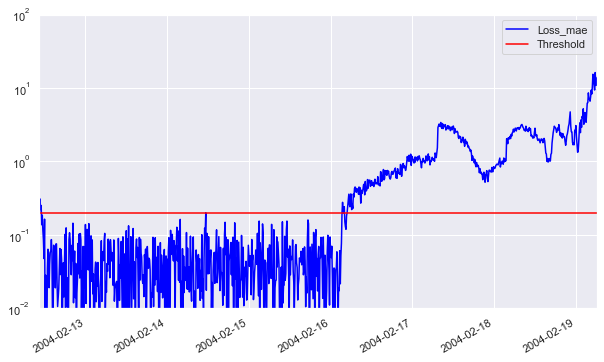

In [16]:
# plot bearing failure time plot
scored.plot(logy=True,  figsize = (10,6), ylim = [1e-2,1e2], color = ['blue','red'])

This analysis approach is able to flag the upcoming bearing malfunction well in advance of the actual failure. It is important to define a suitable threshold value for flagging anomalies while avoiding too many false positives during normal operating conditions.